# Exercise Session 7: Numerical Considerations

The goal of this notebook is to illustrate numerical problems that can arise when implementing numerical methods, and in particular linear regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6) # Default figsize

## Moore-Penrose pseudo inverse

We want to find the solution to the least squares problem for the following dataset:

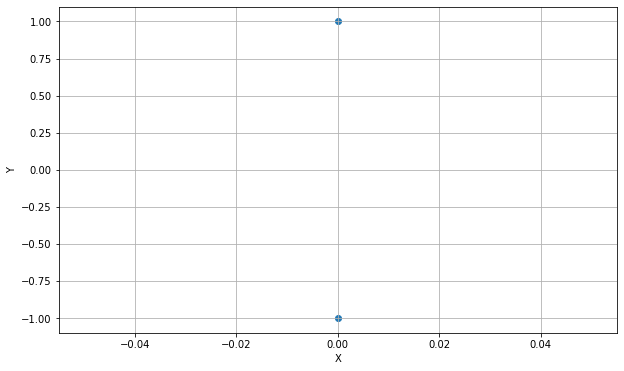

In [2]:
X = np.array([0., 0.])
Y = np.array([-1., 1.])

plt.scatter(X, Y)
plt.grid()
plt.xlabel('X')
_=plt.ylabel('Y')

Let us try to apply the formula from the lecture.

In [3]:
phi = np.vstack((np.ones_like(X),X)).T # Only one feature
w = np.linalg.inv(phi.T @ phi) @ phi.T @ Y

LinAlgError: Singular matrix

The matrix $\Phi^T\Phi$ is not invertible!
This can be immediately seem from the picture: this problem admits many solutions. In fact, all linear functions solve the problem!

Do we have a way to find _one_ of these solutions? The most reasonable seems to be $w = (0,0)$:

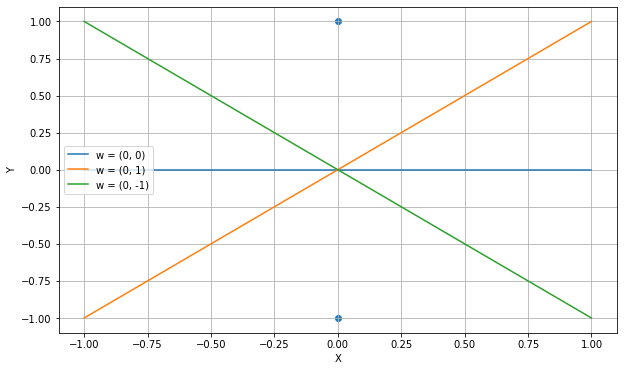

In [4]:
plt.scatter(X, Y)
x_plot = np.linspace(-1, 1, 100)
phi_plot = np.vstack((np.ones_like(x_plot), x_plot)).T
for w in np.array([[0.,0.], [0., 1.], [0., -1.]]):
    plt.plot(x_plot, phi_plot@w, label=f'w = ({w[0]:.0f}, {w[1]:.0f})')
plt.legend(loc='center left')
plt.grid()
plt.xlabel('X')
_=plt.ylabel('Y')

The answer is yes: it is the solution given the Moore-Penrose pseudo-inverse!

Moore-Penrose pseudo inverse of Phi^T \cdot Y: [0. 0.]


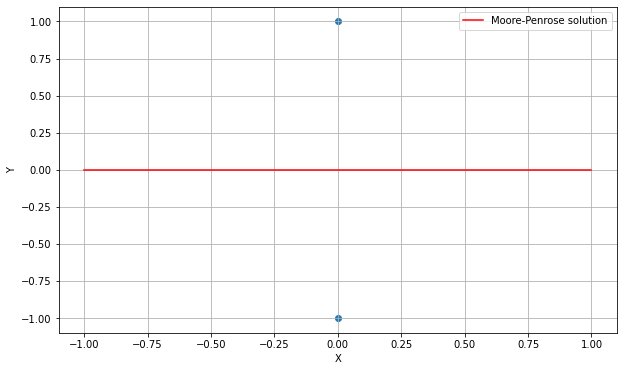

In [5]:
moore_penrose_solution, res, rank, singular_values = np.linalg.lstsq(phi.T @ phi, phi.T @ Y, rcond=None)
print(f'Moore-Penrose pseudo inverse of Phi^T \cdot Y: {moore_penrose_solution}')

x_plot = np.linspace(-1, 1, 100)
phi_plot = np.vstack((np.ones_like(x_plot),x_plot)).T
y_pred = phi_plot @ moore_penrose_solution

plt.scatter(X, Y)
plt.plot(np.linspace(-1, 1, 100), y_pred, label='Moore-Penrose solution', color='r')
plt.legend()
plt.grid()
plt.xlabel('X')
_=plt.ylabel('Y')

We can implement the Moore-Penrose pseudo inverse ourselves from the formula:

In [6]:
u, s, vt = np.linalg.svd(phi.T@phi) # Singular value decomposition
zero_eigen = s < 1e-5
sm1 = np.divide(1, s)
sm1[zero_eigen] = 0
mp_pinv = vt.T @ np.diag(sm1) @ u.T
mp_solution = mp_pinv @ phi.T @ Y
print(f'Moore-Penrose pseudo-inverse:\n{mp_pinv}\nSolution found:\nw = {mp_solution}')

Moore-Penrose pseudo-inverse:
[[0.5 0. ]
 [0.  0. ]]
Solution found:
w = [0. 0.]


/var/folders/zj/14rhk5cx7ms6_rm60m0gk2gw0000gn/T/ipykernel_32821/4244346542.py:3: RuntimeWarning: divide by zero encountered in true_divide
  sm1 = np.divide(1, s)


## Conditioning

This is relevant when a matrix is hard to invert in practice.

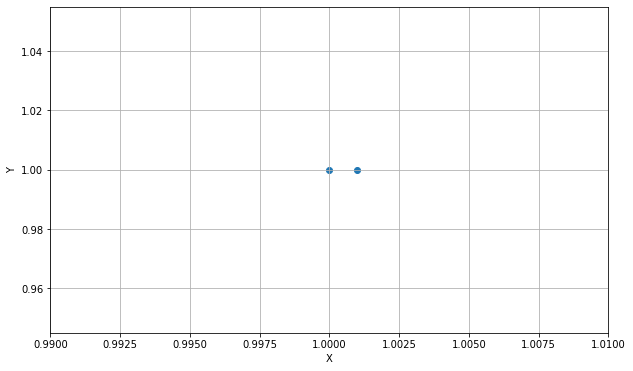

In [7]:
eps = 1e-3
X = np.array([1, 1+eps])
Y = np.array([1, 1])
plt.scatter(X, Y)
plt.grid()
plt.xlim(1 - 10*eps, 1+10*eps)
plt.xlabel('X')
_=plt.ylabel('Y')

The matrix to invert is the following:

In [8]:
phi = np.vstack((np.ones_like(X), X)).T
A = phi.T @ phi
print(A)

[[2.       2.001   ]
 [2.001    2.002001]]


Even if it looks very nice, have a look at what happens:

In [9]:
print(f'Inverse of matrix A:\n{np.linalg.inv(A)}')

Inverse of matrix A:
[[ 2002000.99983748 -2000999.99983756]
 [-2000999.99983756  1999999.99983764]]


The inverse involves **huge** numbers!
Geometrically: if you change $Y$ ever so slightly, the slope changes dramatically!

The mathematical reason is that the eigenvalues of $A$ are different by several orders of magnitude:

In [10]:
np.linalg.eig(A)[0]

array([2.49875016e-07, 4.00200075e+00])

If we add regularization, the condition number decreases:

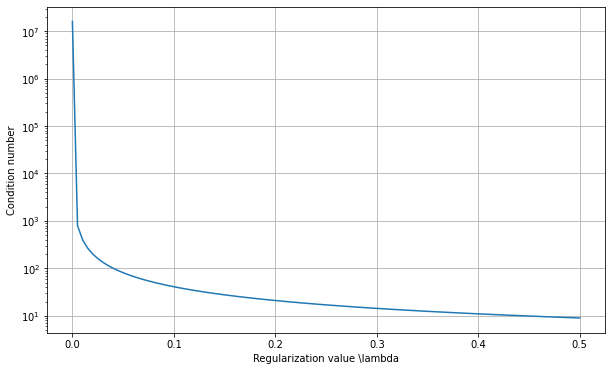

In [11]:
regularizations = np.linspace(0, 0.5, 100)
regularized_conds = [np.linalg.cond(A + l * np.eye(A.shape[0])) for l in regularizations]
plt.semilogy(regularizations, regularized_conds)
plt.grid()
plt.xlabel('Regularization value \lambda')
_=plt.ylabel('Condition number')

This is important: computers make **a lot** of rounding errors

In [12]:
a = 0.1 + 0.1 + 0.1
b = 0.3
print(f'According to a computer, the equality 0.1 + 0.1 + 0.1 = 0.3 is {a==b}')
print(f'The difference is equal to {a - b}')

According to a computer, the equality 0.1 + 0.1 + 0.1 = 0.3 is False
The difference is equal to 5.551115123125783e-17


In fact, computers are **very bad** at handling many different numbers:

In [13]:
print(f'When manipulating wildly different numbers, the computer forgets the smaller decimals: \n'
      f'This should not be equal to 1.0, yet it is the solution found numerically: {(1e20 - 1e3)*1e-20}')

When manipulating wildly different numbers, the computer forgets the smaller decimals: 
This should not be equal to 1.0, yet it is the solution found numerically: 1.0
